In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sorted.read import Reader, to_seg

# sort_path = 'Z:\\0Raw Datasets\\2020\\kfn-inh_sort\\2020-03-03_16-39-42_bsln\\bsln-10m_a'
# sort_path = 'Z:\\0Raw Datasets\\2020\\kfn-inh_sort\\2020-04-24_12-37-06\\bsln-10m-a'
sort_path = 'Z:\\0Raw Datasets\\2020\\kfn-inh_sort\\2020-04-17_15-24-42\\bsln-10m_a'

reader = Reader(sort_path)
dataset = reader.read_to_dict()  # read a Kilsort-sorted dataset into a dictionary
dataset['seg'] = to_seg(dataset)  # convert dataset dictionary to a Neo segment
seg = dataset['seg']

list(dataset)

['amplitudes',
 'channel_map',
 'channel_positions',
 'ei',
 'ie',
 'mp_hp',
 'mp_int',
 'pc_features',
 'pc_feature_ind',
 'similar_templates',
 'spike_clusters',
 'spike_templates',
 'spike_times',
 'templates',
 'templates_ind',
 'template_features',
 'template_feature_ind',
 'whitening_mat',
 'whitening_mat_inv',
 'cluster_group',
 'cluster_info',
 'mmap',
 'fs',
 'expt_id',
 't_start',
 't_stop',
 'seg']

(250.0, 270.0)

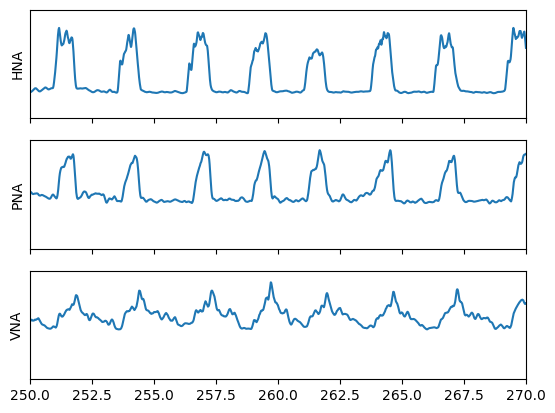

In [2]:
mp = seg.analogsignals[0]
mp_labels = ['HNA', 'PNA', 'VNA']  

fig, axs = plt.subplots(3, 1, sharex=True)
for i in range(3):
    axs[i].plot(mp.times, mp[:, i])
    axs[i].set_yticks([])
    axs[i].set_ylabel(mp_labels[i])
axs[-1].set_xlim((250, 270))

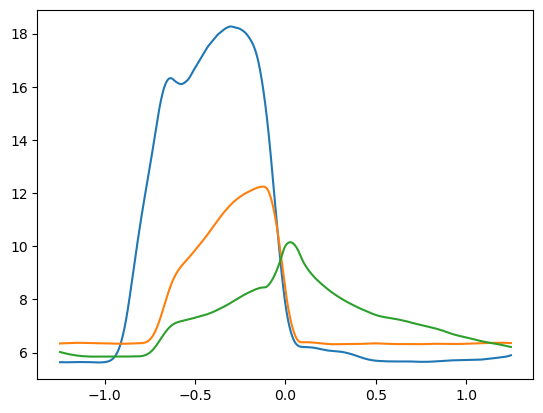

In [3]:
fs = dataset['fs']
T = np.mean(np.diff(dataset['ie']))/fs # if returning [] add axis = 0

sigs = mp.magnitude
win = (-0.5*T, 0.5*T)
events = dataset['ie'].flatten()
fs_avg = 1000
n_bins = int((win[1] - win[0]) * fs_avg)
t = np.linspace(win[0], win[1], num=n_bins)
used = np.zeros(events.shape)
cta = np.zeros((t.shape[0], mp.shape[1]))
for i, ev in enumerate(events):
    if ev+win[0]*fs > mp.t_start.magnitude*fs and ev+win[1]*fs < mp.t_stop.magnitude*fs:
        used[i] = 1
        ind = np.floor(np.linspace((ev+win[0]*fs), (ev+win[1]*fs), num=n_bins))
        cta += sigs[ind.astype(int), :]
cta /= np.sum(used)

plt.plot(t, cta)

np.save("cta_form", cta)

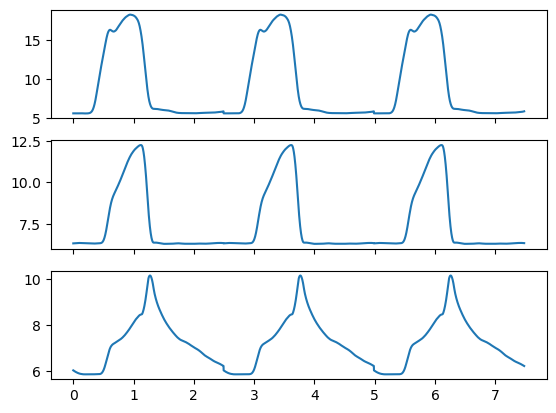

In [4]:
t = np.arange(1/fs_avg, (win[1]-win[0])*3, 1/fs_avg)
fout = np.vstack([cta, cta, cta])

fig, axs = plt.subplots(3, 1, sharex=True)
for i in range(fout.shape[1]):
    axs[i].plot(t, fout[:, i])


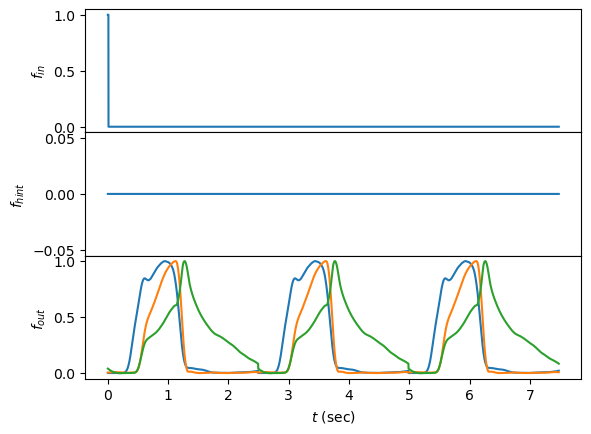

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def inps_and_targs(dt, plot=False):
    t = np.arange(1/fs_avg, (win[1]-win[0])*3, 1/fs_avg)
    rng = np.random.default_rng(123)
    omega = rng.random() * 12
    cta = np.load("cta_form.npy")

    fhint = np.zeros(t.shape)

    fin = np.zeros(t.shape)
    fin[:10] = np.ones(10)

    fin = np.reshape(fin, (1, fin.size)).T
    fhint = np.reshape(fhint, (1, fhint.size)).T
    
    fout = (np.vstack([cta, cta, cta])-np.min(cta, axis=0))/(np.max(cta, axis=0) - np.min(cta,axis=0))
    #fout = np.hstack(y)

    if plot:
        fig, axs = plt.subplots(3, 1, sharex=True)
        plt.subplots_adjust(hspace=0)
        labels = ['$f_{in}$', '$f_{hint}$', '$f_{out}$']
        for ax, y, label in zip(axs, [fin, fhint, fout], labels):
            ax.plot(t, y)
            ax.set_ylabel(label)
        axs[-1].set_xlabel('$t$ (sec)')

    return (fin, fout, fhint)

dt = 0.001
fin, fout, _ = inps_and_targs(dt, plot=True)

In [6]:
cta = np.load("cta_form.npy")
cta.shape

(2493, 3)

Initializing...
Training network...
Batch 1 of 10, 10 trials: 
..........


C:\Users\sq373\OneDrive\Desktop\dhingra lab\full-FORCE\FF_Demo.py:290: UserWarning: Legend does not support handles for dict instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax_out.legend([lines_targ_out,lines_out],['Target','RNN'], loc=1)


Batch 2 of 10, 10 trials: 
..........
Batch 3 of 10, 10 trials: 
..........
Batch 4 of 10, 10 trials: 
..........
Batch 5 of 10, 10 trials: 
..........
Batch 6 of 10, 10 trials: 
..........
Batch 7 of 10, 10 trials: 
..........
Batch 8 of 10, 10 trials: 
..........
Batch 9 of 10, 10 trials: 
..........
Batch 10 of 10, 10 trials: 
..........
Done training!


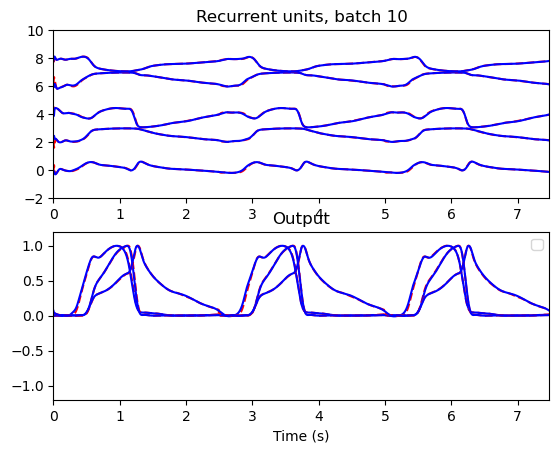

In [7]:
import FF_Demo as ff

p = ff.create_parameters()
p['ff_trials_per_batch'] = 10
net = ff.RNN(p, 1, 3)

net.train(inps_and_targs, monitor_training=0)

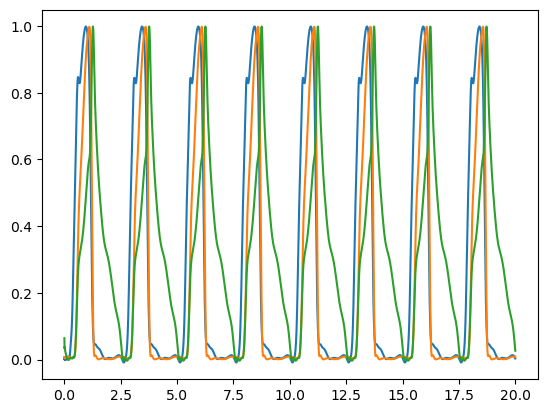

In [9]:
dt = 0.001
t = np.arange(0, 20, dt)
fin_test = np.zeros(t.shape)
fin_test[:10] = np.ones(10)

z, x = net.run(fin_test, record_flag=1) #z is output, x is internal activities

plt.plot(t, z)
#plt.figsize(6, 12)

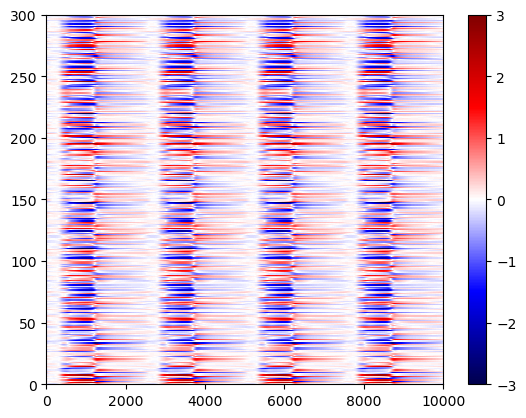

In [10]:
pcm = plt.pcolormesh(x[-10*1000:].T, cmap=plt.get_cmap('seismic'), vmin = -3, vmax = 3)
fig.colorbar(pcm)

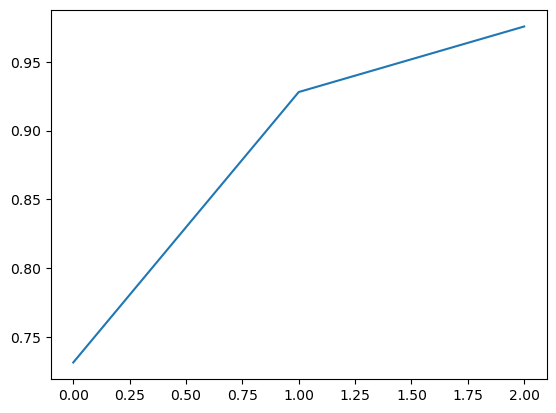

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3, whiten = True) #only need 3 PCAs
pca.fit(x.T)
pca.explained_variance_ratio_ 
plt.plot(np.cumsum(pca.explained_variance_ratio_))

xw = pca.transform(x.T)

In [14]:
from sklearn.cluster import KMeans

xw.shape # 300 units reduced to 3 data points

k = np.arange(2, 50) # number of clusters
sse = np.zeros(k.shape[0]) # sum squared errors for each k

for i, n in enumerate(k):
    km = KMeans(n_clusters = n, n_init = 'auto')
    km.fit(xw)
    sse[i] = km.inertia_

C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\sklearn\cluster\_kmeans.py:14

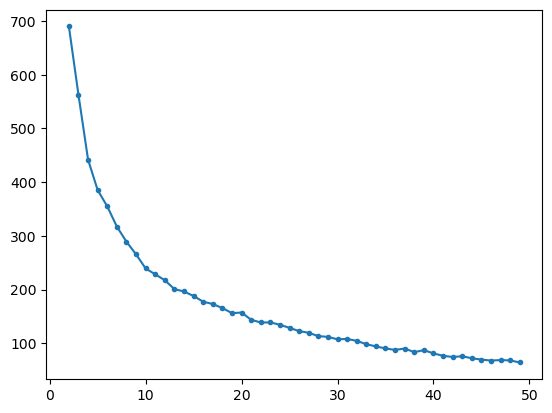

In [15]:
plt.plot(k, sse, '.-')

C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


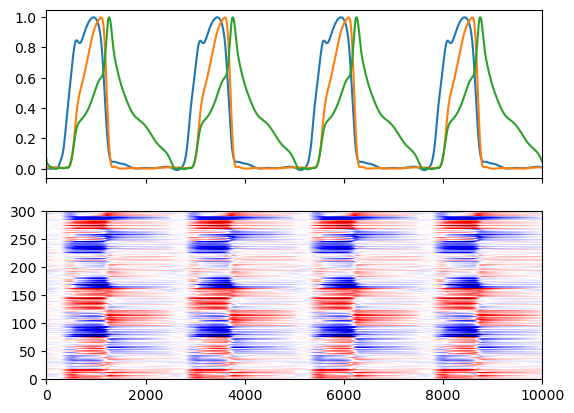

In [40]:
km = KMeans(n_clusters = 14, n_init = 'auto')
km.fit(xw)

idx = np.argsort(km.labels_)

#xw = xw[idx]

#pcm_clust = plt.pcolormesh(x[-10*1000:, idx].T, cmap=plt.get_cmap('seismic'), vmin = -3, vmax = 3)
fig, axs = plt.subplots(2, 1, sharex = True)
fig.subplots_adjust(hspace=None)
axs[0].plot(z[:10000])
axs[1].pcolormesh(x[-10*1000:, idx].T, cmap=plt.get_cmap('seismic'), vmin = -3, vmax = 3)

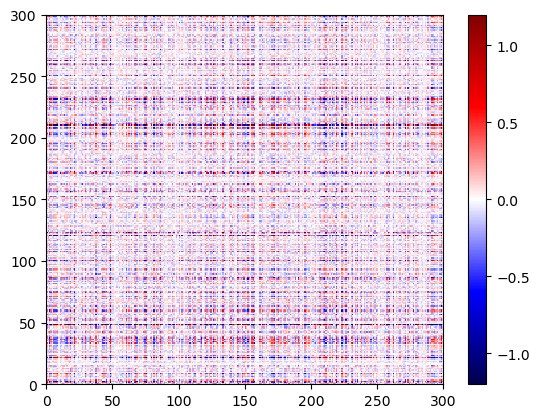

In [21]:
from scipy.cluster import hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance_matrix

J = net.rnn_par['rec_weights']
D = distance_matrix(J, J)

clustering = AgglomerativeClustering(n_clusters = 10).fit(J)

inds = clustering.labels_.argsort(kind = 'stable')

fig, ax = plt.subplots()
pcm = ax.pcolormesh(J, cmap=plt.get_cmap('seismic'), vmin=-1.2, vmax=1.2)
fig.colorbar(pcm)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.spatial import distance_matrix

# Generate random features and distance matrix.
J = net.rnn_par['rec_weights']
D = distance_matrix(J, J)

# condensedD = squareform(D)

# # Compute and plot first dendrogram.
# fig = plt.figure(figsize=(8, 8))
# ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
# Y = sch.linkage(condensedD, method='centroid')
# Z1 = sch.dendrogram(Y, orientation='left')
# ax1.set_xticks([])
# ax1.set_yticks([])

# # Compute and plot second dendrogram.
# ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
# Y = sch.linkage(condensedD, method='single')
# Z2 = sch.dendrogram(Y)
# ax2.set_xticks([])
# ax2.set_yticks([])

# # Plot distance matrix.
# axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
# idx1 = Z1['leaves']
# idx2 = Z2['leaves']
# J = J[idx1,:]
# J = J[:,idx2]
# im = axmatrix.matshow(J, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
# axmatrix.set_xticks([])  # remove axis labels
# axmatrix.set_yticks([])  # remove axis labels

# # Plot colorbar.
# axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
# plt.colorbar(im, cax=axcolor)
# plt.show()
# fig.savefig('dendrogram.png')

In [28]:
distance_matrix(J, J)

array([[ 0.        ,  6.2973173 ,  8.72483678, ...,  4.15861735,
         6.26684678,  2.56628346],
       [ 6.2973173 ,  0.        , 12.69832265, ...,  6.71794498,
        10.05651432,  5.10630867],
       [ 8.72483678, 12.69832265,  0.        , ...,  6.23855434,
         4.33331429,  8.18702126],
       ...,
       [ 4.15861735,  6.71794498,  6.23855434, ...,  0.        ,
         3.65141155,  2.54189542],
       [ 6.26684678, 10.05651432,  4.33331429, ...,  3.65141155,
         0.        ,  5.45442262],
       [ 2.56628346,  5.10630867,  8.18702126, ...,  2.54189542,
         5.45442262,  0.        ]])

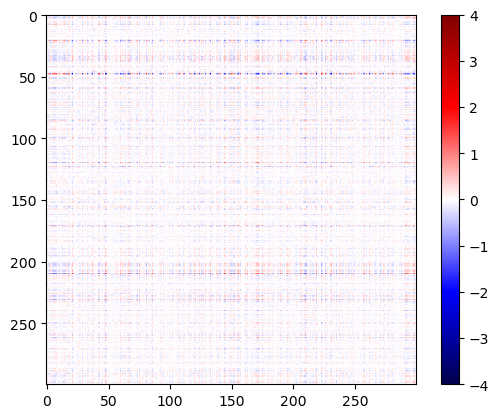

In [37]:
plt.imshow(J, cmap=plt.get_cmap('seismic'), vmin=-4, vmax=4)
plt.colorbar()

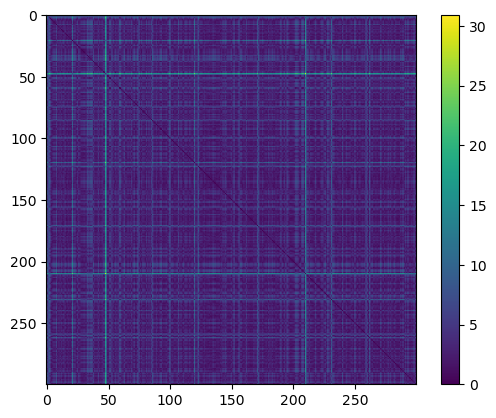

In [31]:
plt.imshow(distance_matrix(J, J))
plt.colorbar()

C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\sq373\anaconda3\envs\full-FORCE\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


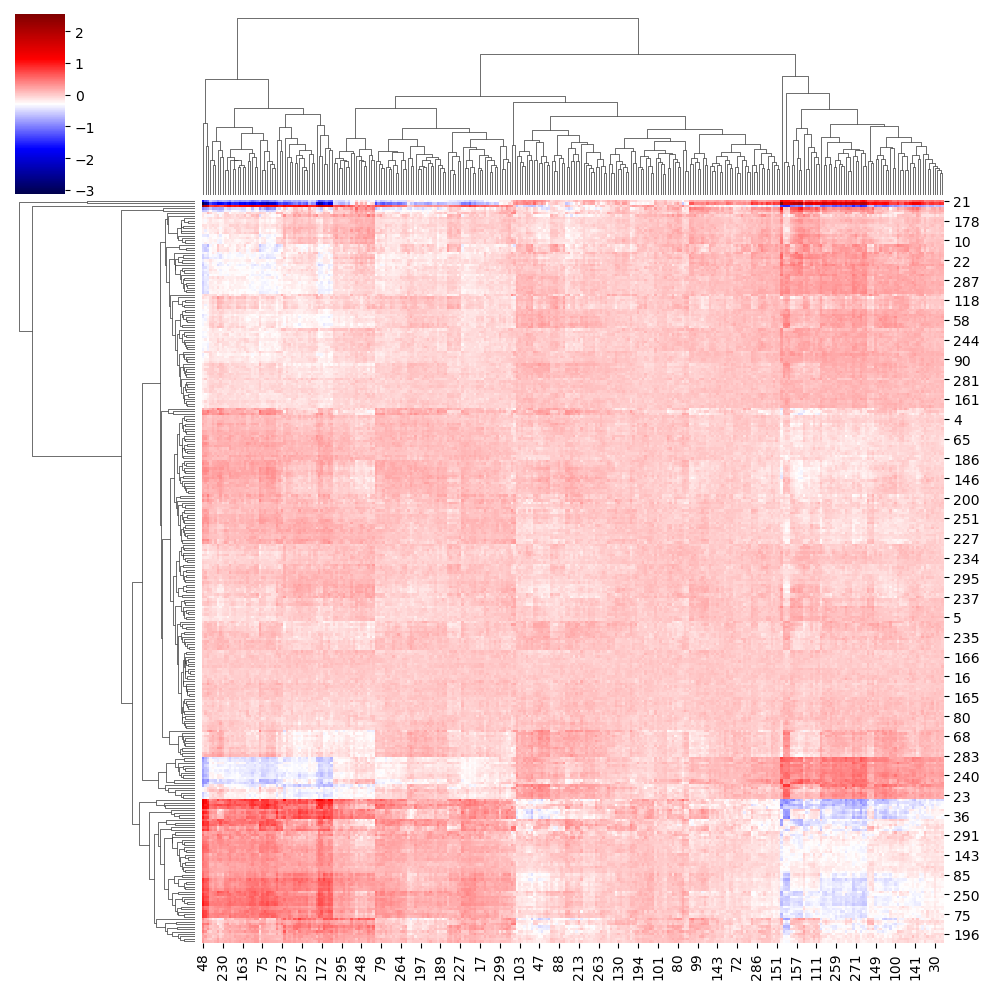

In [32]:
import seaborn as sns

sns.clustermap(J, cmap='seismic')

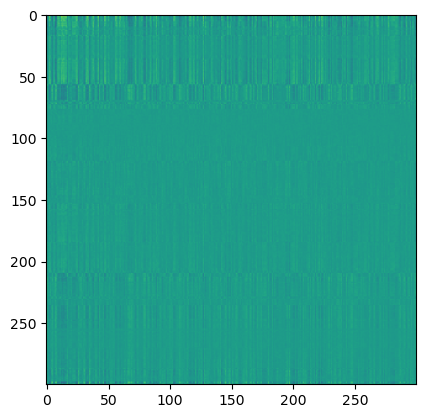

In [25]:
plt.imshow(J)